Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [5]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
import re
%matplotlib inline
import xgboost

In [ ]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

# 2 categories to class today
categories = ['alt.atheism',
              'talk.religion.misc']

data = fetch_20newsgroups(subset='all', 
                          categories=categories)

In [ ]:
# prep data, instantiate a model, create pipeline object, and run a gridsearch 

len(data.data)

1427

In [ ]:
data.data[0]

'From: agr00@ccc.amdahl.com (Anthony G Rose)\nSubject: Re: Who\'s next?  Mormons and Jews?\nReply-To: agr00@JUTS.ccc.amdahl.com (Anthony G Rose)\nOrganization: Amdahl Corporation, Sunnyvale CA\nLines: 18\n\nIn article <1993Apr20.142356.456@ra.royalroads.ca> mlee@post.RoyalRoads.ca (Malcolm Lee) writes:\n>\n>In article <C5rLps.Fr5@world.std.com>, jhallen@world.std.com (Joseph H Allen) writes:\n>|> In article <1qvk8sINN9vo@clem.handheld.com> jmd@cube.handheld.com (Jim De Arras) writes:\n>|> \n>|> It was interesting to watch the 700 club today.  Pat Robertson said that the\n>|> "Branch Dividians had met the firey end for worshipping their false god." He\n>|> also said that this was a terrible tragedy and that the FBI really blew it.\n>\n>I don\'t necessarily agree with Pat Robertson.  Every one will be placed before\n>the judgement seat eventually and judged on what we have done or failed to do\n>on this earth.  God allows people to choose who and what they want to worship.\n\nI\'m sorry,

In [ ]:
data.data[1]

'From: frank@D012S658.uucp (Frank O\'Dwyer)\nSubject: Re: Tieing Abortion to Health Reform -- Is Clinton Nuts?\nOrganization: Siemens-Nixdorf AG\nLines: 21\nNNTP-Posting-Host: d012s658.ap.mchp.sni.de\n\nIn article <1993Apr26.163627.11364@csrd.uiuc.edu> g-skinner@uiuc.edu writes:\n#I find myself unable to put these two statements together in a\n#sensible way:\n#\n#>Abortion is done because the mother can not afford the *pregnancy*.\n#\n#[...]\n#\n#>If we refused to pay for the more expensive choice of birth, *then*\n#>your statement would make sense.  But that is not the case, so it doesn\'t.\n#\n#Are we paying for the birth or not, Mr. Parker?  If so, why can\'t the\n#mother afford the pregnancy?  If not, what is the meaning of the\n#latter objection?  You can\'t have it both ways.\n\nBirth != pregnancy.  If they were the same, the topic of abortion would \nhardly arise, would it, Mr. Skinner?\n\n-- \nFrank O\'Dwyer                                  \'I\'m not hatching That\'\nodwyer@ss

In [ ]:
def clean_data(text):
    
    # remove newline characters
    text = re.sub('\n', ' ', text)
    
    # remove email addresses
    # from the beginning of the text
    text = re.sub('From: \S*@\S*\s?', ' ', text)
    # from the middle of the text
    text = re.sub('\S*@\S*\s?', ' ', text)
    
    # remove apostrophes
    text = re.sub("'", '', text)
    
    # remove punctuation
    text = re.sub('[^a-zA-Z 0-9]', ' ', text)
    
    # remove "Reply To"
    text = re.sub("Reply To", ' ', text)
    
    # remove newline characters
    # everything that is more than one space
    # replace it with just a single space
    text = re.sub("[ ]{2,}", ' ', text)
    
    return text.lower().strip()
    
clean_data(data.data[1])

'frank odwyer subject re tieing abortion to health reform is clinton nuts organization siemens nixdorf ag lines 21 nntp posting host d012s658 ap mchp sni de in article writes i find myself unable to put these two statements together in a sensible way abortion is done because the mother can not afford the pregnancy if we refused to pay for the more expensive choice of birth then your statement would make sense but that is not the case so it doesnt are we paying for the birth or not mr parker if so why cant the mother afford the pregnancy if not what is the meaning of the latter objection you cant have it both ways birth pregnancy if they were the same the topic of abortion would hardly arise would it mr skinner frank odwyer im not hatching that from hens by evelyn conlon'

In [ ]:
# Baseline Accuracy?
1 - (sum(data.target) / len(data.target))

0.559915907498248

In [ ]:
# Can't use .apply() because it's not in a dataframe
# use a list-comprehension instead

X = [clean_data(text) for text in data.data]
y = data.target

# Create a Pipeline,
# include TfidfVectorizer as a step of the pipeline

# instantiate my TfidfVectorizer and RandomForest *before* putting them in the pipeline
pipe = Pipeline([('vect', TfidfVectorizer(stop_words='english')),
                 ('clf', RandomForestClassifier())])


param_grid = {
    'vect__max_df': [.75, 1.0],
    'clf__max_depth': [5,10,15,20]
}

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-2, verbose=1)

# fit me the model and do cross validation
grid_search.fit(X,y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed:    4.9s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'clf__max_depth': [5, 10, 15, 20],
                         'vect__max_df': [0.75, 1.0]},
             verbose=1)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'clf__max_depth': 20, 'vect__max_df': 0.75}
Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.75, stop_words='english')),
                ('clf', RandomForestClassifier(max_depth=20))])
0.8654474421347486


## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1538411402/image3_maagmh.png)

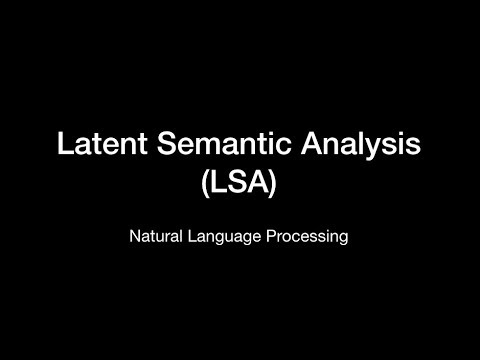

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('OvzJiur55vo', width=1024, height=576)

### First an example

Before we apply Latent Semantic Analysis in a pipeline, let's work through a simple example together in order to better understand how LSA works and develop an intuition along the way. 

First, if you haven't already, watch the short video provided above. We will be implementing the example from the video in our notebook. 

In [ ]:
# Import

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

svd = TruncatedSVD(n_components=2, # number of topics to generate (also the size of the new feature space)
                  )

# let's use the same data that was used in the video for consistancy 

        # topic 1 data 
data = ["pizza", 
        "hamburger", 
        "cookie", 
        "pizza hamburger cookie",
        # topic 2 data
        "ramen", 
        "sushi", 
        "ramen sushi"]

In [ ]:
# CREATE Term-Frequency matrix 

# YOUR CODE HERE
vectorizer = CountVectorizer()
tfm = vectorizer.fit_transform(data)
tfm = pd.DataFrame(data=tfm.toarray(), columns=vectorizer.get_feature_names())

tfm.index = data

tfm.head(7)

,cookie,hamburger,pizza,ramen,sushi
pizza,0,0,1,0,0
hamburger,0,1,0,0,0
cookie,1,0,0,0,0
pizza hamburger cookie,1,1,1,0,0
ramen,0,0,0,1,0
sushi,0,0,0,0,1
ramen sushi,0,0,0,1,1


In [ ]:
# Use SVD to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality


# YOUR CODE HERE
X_reduced = svd.fit_transform(tfm)

X_reduced.round(2)

array([[ 0.58,  0.  ],
       [ 0.58,  0.  ],
       [ 0.58, -0.  ],
       [ 1.73,  0.  ],
       [ 0.  ,  0.71],
       [-0.  ,  0.71],
       [ 0.  ,  1.41]])

In [ ]:
# YOUR CODE HERE
topic_cols = ['topic_1', 'topic_2']
dtm_reduced = pd.DataFrame(data=X_reduced.round(2), columns=topic_cols)
dtm_reduced.index=data

dtm_reduced.head(7)

,topic_1,topic_2
pizza,0.58,0.00
hamburger,0.58,0.00
cookie,0.58,-0.00
pizza hamburger cookie,1.73,0.00
ramen,0.00,0.71
sushi,-0.00,0.71
ramen sushi,0.00,1.41


Ok, now that we have gone through an example of applying LSA on a small dataset, let's apply it in a model building pipeline. 

In [ ]:
# build a pipeline, incorporate SVD, and run a gridsearch 

svd = TruncatedSVD(n_components=100)
tfidf = TfidfVectorizer(stop_words='english')
rfc = RandomForestClassifier()

# Nested Pipelines
# put a pipeline inside of a pipeline

lsa = Pipeline([('vect', tfidf),
                ('svd', svd)])

pipe = Pipeline([('lsa', lsa),
                 ('clf', rfc)])

# Nested pipelines change how we write our param_grid
param_grid = {'lsa__svd__n_components': [2],
              'clf__max_depth': [5,10,15,20]}

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-2, verbose=1)

grid_search.fit(X,y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  12 | elapsed:    2.9s remaining:    5.8s
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:    3.6s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('lsa',
                                        Pipeline(steps=[('vect',
                                                         TfidfVectorizer(stop_words='english')),
                                                        ('svd',
                                                         TruncatedSVD(n_components=100))])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'clf__max_depth': [5, 10, 15, 20],
                         'lsa__svd__n_components': [2]},
             verbose=1)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'clf__max_depth': 5, 'lsa__svd__n_components': 2}
Pipeline(steps=[('lsa',
                 Pipeline(steps=[('vect',
                                  TfidfVectorizer(stop_words='english')),
                                 ('svd', TruncatedSVD())])),
                ('clf', RandomForestClassifier(max_depth=5))])
0.6888589119858469


In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')

newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


In [ ]:
!pwd

/Users/ryanallred/Desktop/DS-Unit-4-Sprint-1-NLP/module3-document-classification


In [ ]:
X_train = pd.read_csv('whiskey-reviews-ds28/train.csv')

X_train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [ ]:
X_test = pd.read_csv('whiskey-reviews-ds28/test.csv')

X_test.head()

,id,description
0,3461,\nStyle: Speyside single malt scotch Color: Wa...
1,2604,"\nVery bright and lively, with a nice balance ..."
2,3341,\nA new oloroso-forward Chivas positioned to s...
3,3764,\nAged in bourbon casks and then enhanced in R...
4,2306,\nThere is a freshness to the wood on the nose...


## clean up our text data

In [ ]:
X_train['description'][0]

'sometimes when whisky is batched a few leftover barrels are returned to the warehouse canadian club recently pulled and vatted several of these from the 1970s acetone granny smith apples and fresh cut white cedar showcase this long age complex and spicy yet reserved this dram is ripe with strawberries canned pears cloves pepper and faint flowers then slightly pulling oak tannins distinct elegant and remarkably vibrant this ancient canadian club is anything but tired australia only a 133'

In [ ]:
clean_data(X_train['description'][0])

'sometimes when whisky is batched a few leftover barrels are returned to the warehouse canadian club recently pulled and vatted several of these from the 1970s acetone granny smith apples and fresh cut white cedar showcase this long age complex and spicy yet reserved this dram is ripe with strawberries canned pears cloves pepper and faint flowers then slightly pulling oak tannins distinct elegant and remarkably vibrant this ancient canadian club is anything but tired australia only a 133'

In [ ]:
X_train['description'] = X_train['description'].apply(clean_data)
X_test['description'] = X_test['description'].apply(clean_data)

X_train

,id,description,ratingCategory
0,1321,sometimes when whisky is batched a few leftove...,1
1,3861,an uncommon exclusive bottling of a 6 year old...,0
2,655,this release is a port version of amrut s inte...,1
3,555,this 41 year old single cask was aged in a she...,1
4,1965,quite herbal on the nose with aromas of dried ...,1
...,...,...,...
4082,3342,what lies beneath the surface of dewar s here ...,1
4083,3130,after 6 to 7 years of maturation in bourbon ca...,1
4084,2811,bright delicate and approachable while not a s...,1
4085,478,i m calling this the pitmaster s dram the nose...,1


In [ ]:
X = X_train['description']
y = X_train['ratingCategory']

In [ ]:
# build a pipeline, incorporate SVD, and run a gridsearch 

svd = TruncatedSVD(n_components=100)
tfidf = TfidfVectorizer(stop_words='english')
rfc = RandomForestClassifier()

# Nested Pipelines
# put a pipeline inside of a pipeline

lsa = Pipeline([('vect', tfidf),
                ('svd', svd)])

pipe = Pipeline([('lsa', lsa),
                 ('clf', rfc)])

# Nested pipelines change how we write our param_grid
param_grid = {'lsa__svd__n_components': [10, 25, 50, 75],
              'clf__max_depth': [6, 8, 10, 12, 14]}

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-2, verbose=1)

grid_search.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:   15.3s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('lsa',
                                        Pipeline(steps=[('vect',
                                                         TfidfVectorizer(stop_words='english')),
                                                        ('svd',
                                                         TruncatedSVD(n_components=100))])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'clf__max_depth': [6, 8, 10, 12, 14],
                         'lsa__svd__n_components': [10, 25, 50, 75]},
             verbose=1)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'clf__max_depth': 14, 'lsa__svd__n_components': 50}
Pipeline(steps=[('lsa',
                 Pipeline(steps=[('vect',
                                  TfidfVectorizer(stop_words='english')),
                                 ('svd', TruncatedSVD(n_components=50))])),
                ('clf', RandomForestClassifier(max_depth=14))])
0.7281647082229498


## Kaggle Submission

In [ ]:
X_test.head()

,id,description,predictions
0,3461,style speyside single malt scotch color walnut...,1
1,2604,very bright and lively with a nice balance of ...,1
2,3341,a new oloroso forward chivas positioned to spl...,1
3,3764,aged in bourbon casks and then enhanced in rio...,1
4,2306,there is a freshness to the wood on the nose l...,1


In [ ]:
predictions = grid_search.predict(X_test['description'])

In [ ]:
X_test['ratingCategory'] = predictions

In [ ]:
X_test.head()

,id,description,predictions,ratingCategory
0,3461,style speyside single malt scotch color walnut...,1,1
1,2604,very bright and lively with a nice balance of ...,1,1
2,3341,a new oloroso forward chivas positioned to spl...,1,1
3,3764,aged in bourbon casks and then enhanced in rio...,1,1
4,2306,there is a freshness to the wood on the nose l...,1,1


In [ ]:
X_test[['id', 'ratingCategory']].to_csv('submission.csv', index=False)

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [2]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=eeaa9d464453eaf2734fe571325dfca7722a9a6f3a0fde332a87c2858a6ab74c
  Stored in directory: /tmp/pip-ephem-wheel-cache-l1tu9_yy/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import spacy
import pandas as pd

# build a model that is trained on word vectors 

# load in pre-trained w2v model 
nlp = spacy.load("en_core_web_md")

###BEGIN SOLUTION
def get_word_vectors(docs):
    """
    This serves as both our tokenizer and vectorizer. 
    Returns a list of word vectors, i.e. our doc-term matrix
    """
    return [nlp(doc).vector for doc in docs]

import pandas as pd

# You may need to change the path
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')

# create our doc-term matrices 

# raw text data for train and test sets
X_train_text = train["description"]
X_test_text = test["description"]

# transform raw data into doc-term matrices for train and test sets 
X_train = get_word_vectors(X_train_text)
X_test = get_word_vectors(X_test_text)

# save ratings to y vector
Y_train = train["ratingCategory"]

# create RF model, use oob ?
rfc = RandomForestClassifier(oob_score=True)

rfc.fit(X_train, Y_train)
###END SOLUTION

In [ ]:
# training accuracy
rfc.score(X_train, Y_train)

0.9997553217518963

In [ ]:
rfc.predict(X_test)

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
# look at the word embeddings for curiosity's sake
pd.DataFrame(data=X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.089614,0.211095,-0.146578,-0.114795,0.024769,-0.001865,-0.076890,-0.049576,-0.041997,1.485818,...,-0.087667,0.074185,-0.180197,-0.047222,-0.186401,0.081628,0.085428,-0.237279,-0.104687,0.078887
1,-0.064173,0.219003,-0.105846,-0.054408,0.043035,0.081874,-0.070914,-0.091803,-0.025953,1.730558,...,-0.150704,0.062309,-0.080068,-0.084943,-0.158318,0.035687,0.047953,-0.252308,-0.039156,0.111129
2,-0.064698,0.233368,-0.090879,-0.075978,0.103789,0.005003,-0.024820,-0.073962,-0.024440,1.521340,...,-0.072031,0.023876,-0.085432,-0.077401,-0.127529,0.047653,0.068493,-0.234227,-0.066140,0.129101
3,-0.102365,0.184899,-0.114024,-0.133678,0.113843,-0.002190,-0.098352,-0.011365,-0.039665,1.490252,...,-0.099472,0.031247,-0.141217,-0.104183,-0.267152,0.031445,0.085589,-0.309842,-0.078214,0.097184
4,-0.011103,0.171984,-0.127995,-0.021039,0.006549,0.048551,-0.116974,-0.028143,-0.017360,1.632868,...,-0.140738,0.072687,-0.048316,-0.152608,-0.166986,0.039122,0.127793,-0.230496,-0.103196,0.144841


In [ ]:
test['ratingCategory'] = rfc.predict(X_test)

test.head()

,id,description,ratingCategory
0,3461,\nStyle: Speyside single malt scotch Color: Wa...,1
1,2604,"\nVery bright and lively, with a nice balance ...",1
2,3341,\nA new oloroso-forward Chivas positioned to s...,1
3,3764,\nAged in bourbon casks and then enhanced in R...,1
4,2306,\nThere is a freshness to the wood on the nose...,1


In [ ]:
test[['id', 'ratingCategory']].to_csv('submission.csv', index=False)

## Follow Along

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on